# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
#!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [5]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [6]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

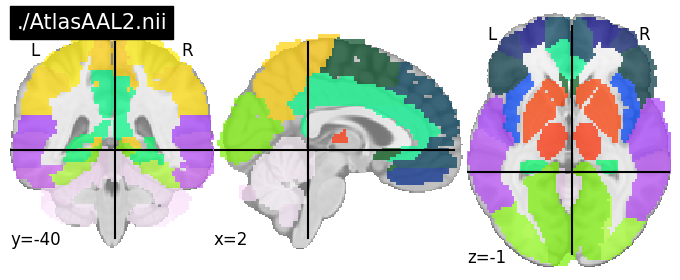

In [7]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [8]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

the minimum value of our data = 0.0


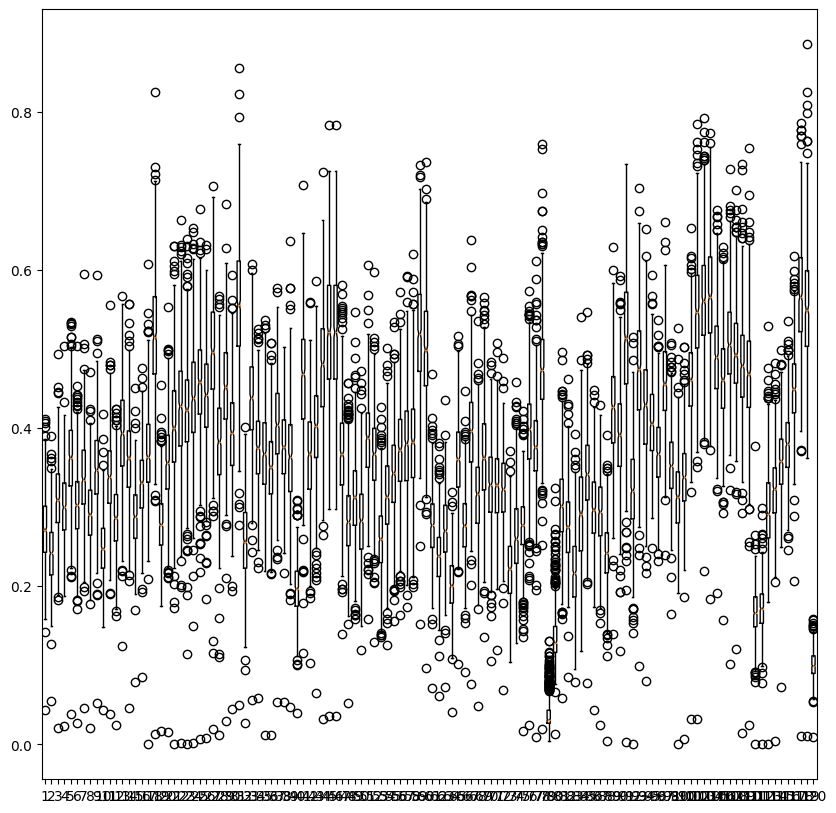

In [9]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

print(f"the minimum value of our data = {X.min()}")

Since our data is always bigger than zero, we'll use normalization.

In [10]:
# Normalization
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [11]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7345132743362832


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  5


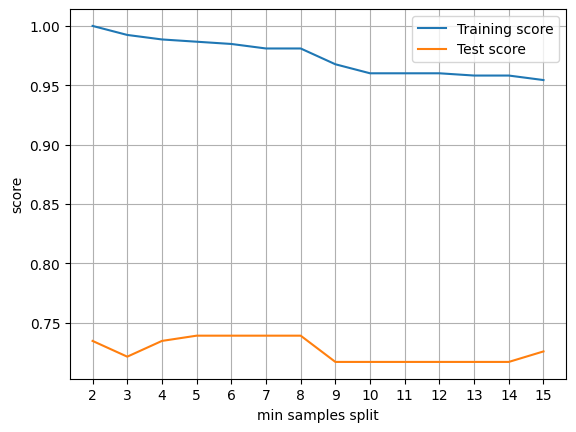

In [12]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.grid()
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  11


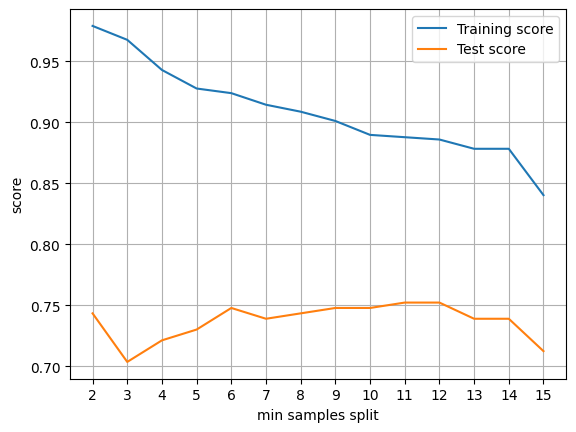

In [13]:
# min_samples_leaf

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.grid()
plt.legend();

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

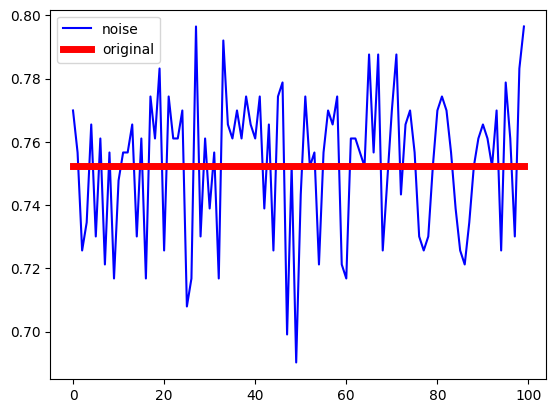

In [14]:
Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=11, random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)  

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        mu, sigma = 0, 1e-2
        X_train_temp[i] = X_train[i] + np.abs(np.random.normal(mu, sigma))
        
    Tree.fit(X_train_temp, y_train)
    scoreTestnoise[k] = Tree.score(X_test, y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

It's visible how the tree method is sensible to small variations in the data. It could be explained by the hierarchical flow of the method. It means, if the first step is sligthy different, all the others steps will have results with bigger differences.

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

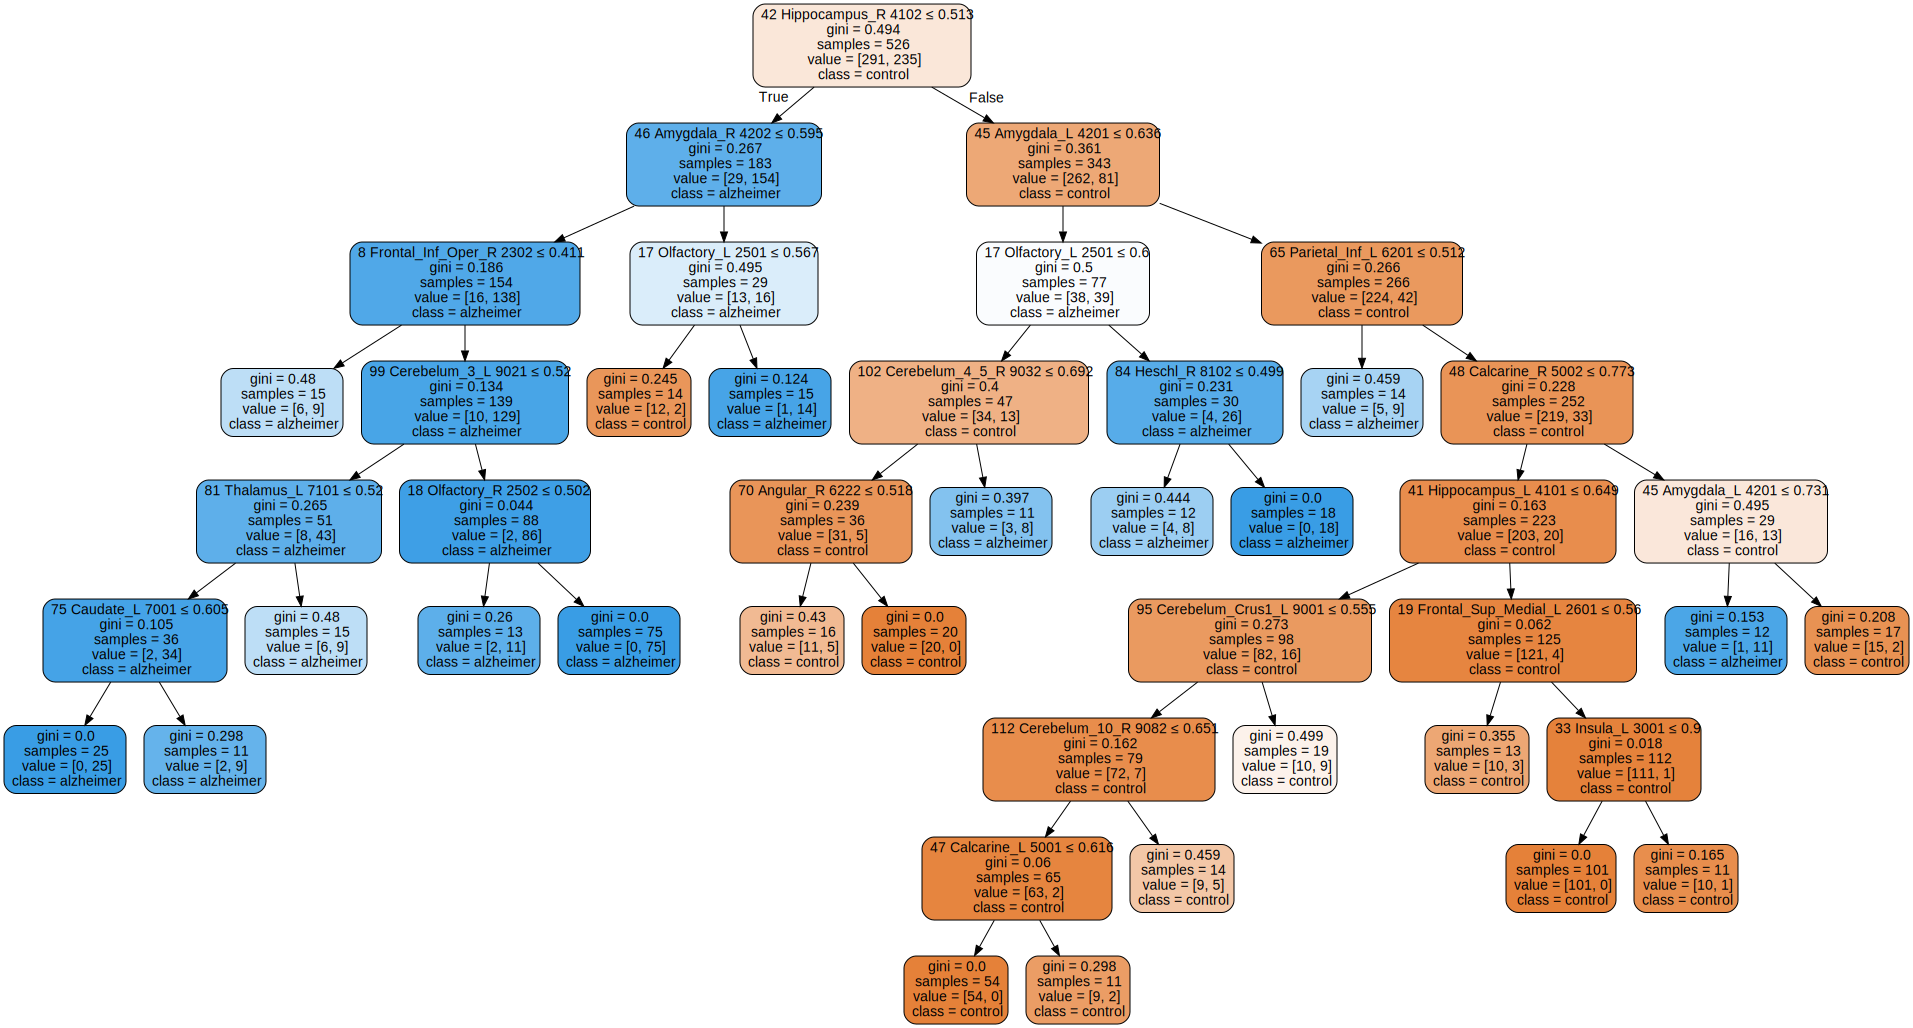

In [15]:
#!pip install graphviz 
import graphviz 
Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=11, random_state=0)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

We can see that the comparisons are different even it made with sligthy different data (low variance) .

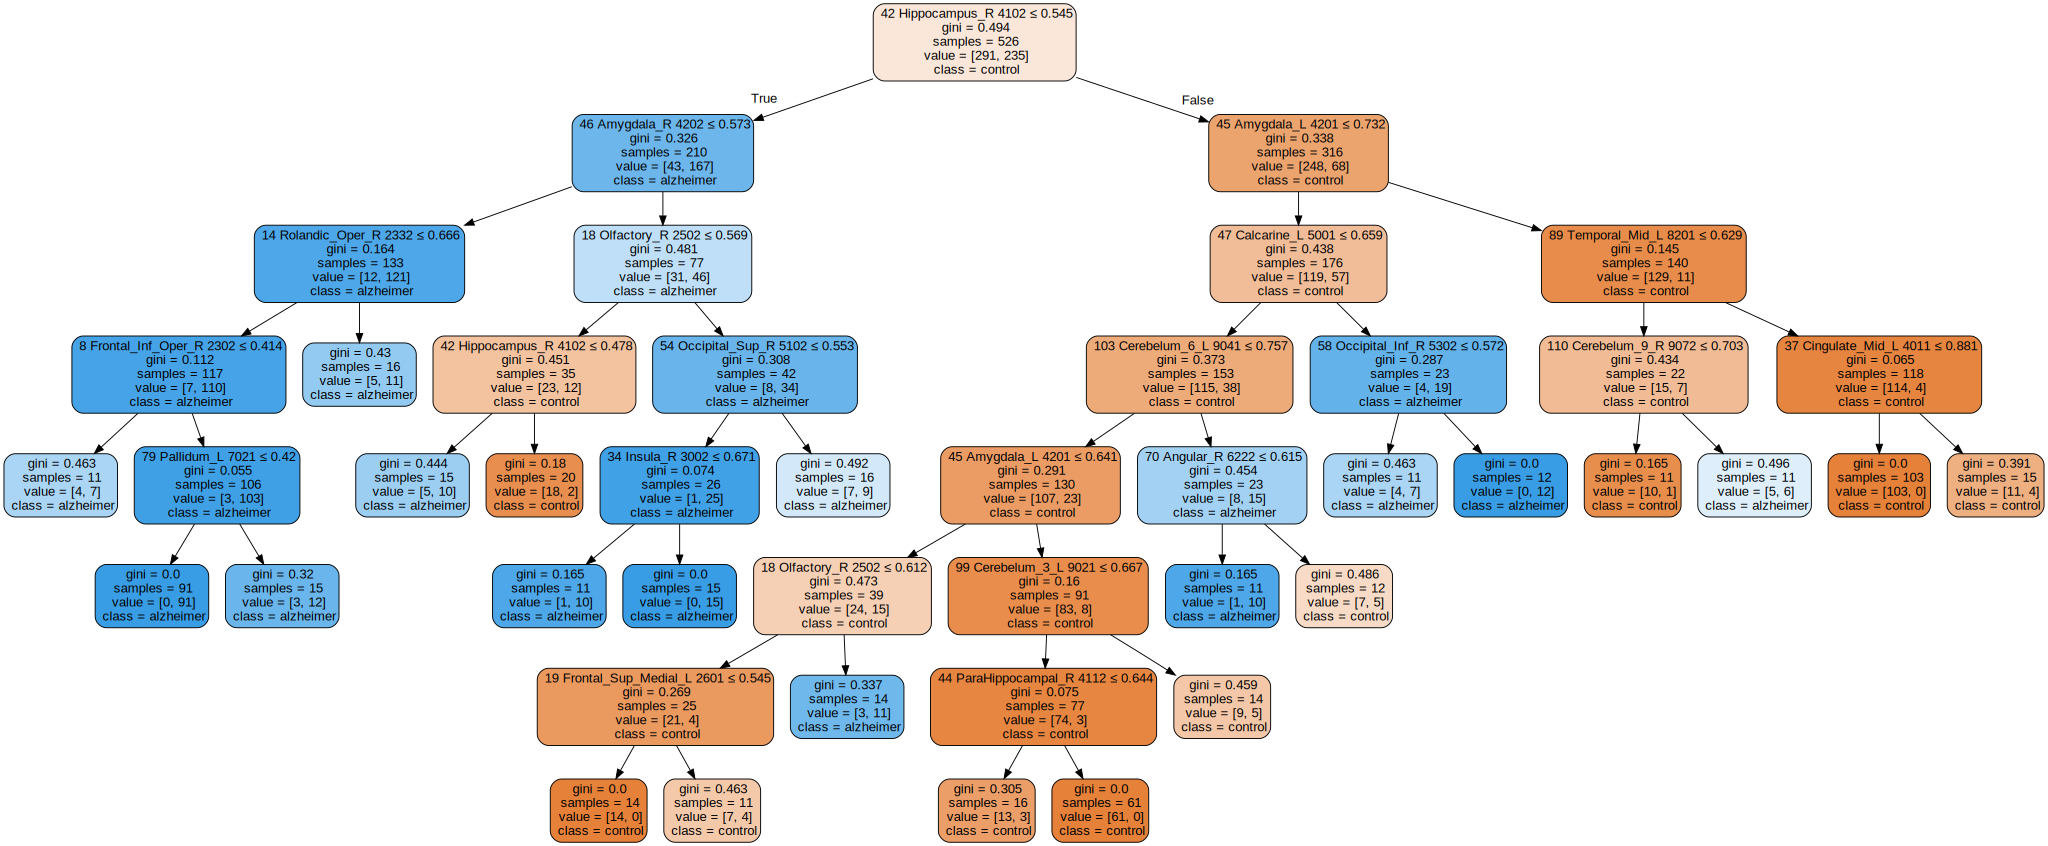

In [16]:
Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=11, random_state=0)
Tree.fit(X_train_temp, y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

With this data, on the second step compares Amygdala with a different threshold 

---

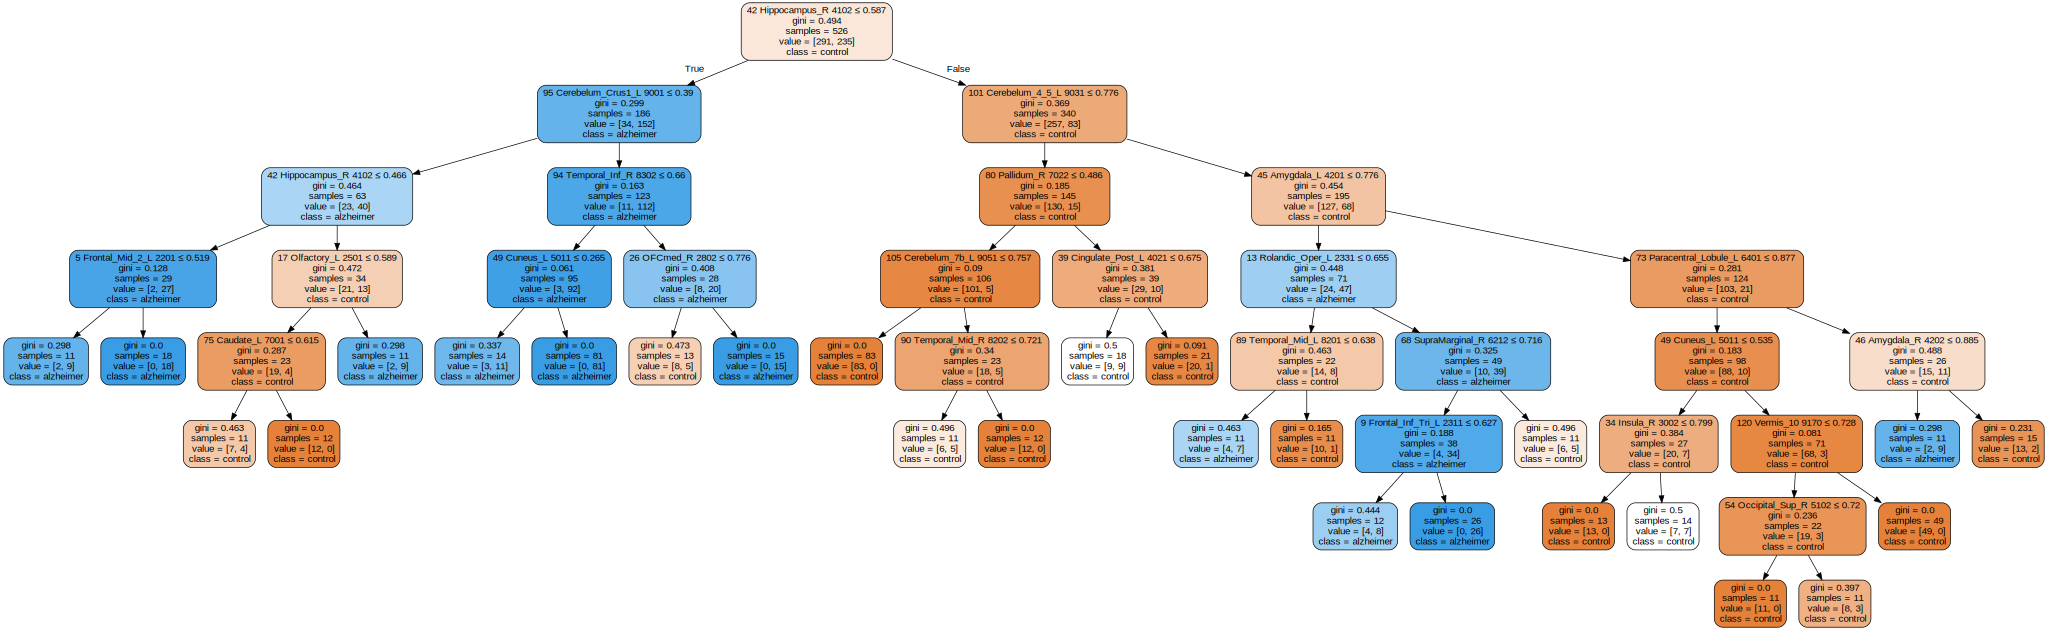

In [16]:
for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        mu, sigma = 0, 1e-1
        X_train_temp[i] = X_train[i] + np.abs(np.random.normal(mu, sigma))

Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=11, random_state=0)
Tree.fit(X_train_temp, y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

With this data, on the second step the algorithm compares Cerebelum instead of Amygdala 

---


Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Answer:** 
No, the optimal previous hyperparameters were: min_sample_split =  5 and  min_sample_leaf =  11.
The obtained ones using cross validation are:  min_sample_split = 2 and  min_sample_leaf = 14

In [19]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split': [i for i in range(2,16)],
               'min_samples_leaf':  [i for i in range(2,16)]} 
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7680682839173406
Best params: {'min_samples_leaf': 14, 'min_samples_split': 2}
Tree test score : 0.7389380530973452


**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:** 
Since our model is working with medical data, accuracy is not the best metric score. It could be explain by the fact that on this scenario is better that our model be wrong saying that someone is sick then that person be accompanied by a professional but in fact this person is healthy than the contrary case where our model can compromise someone's life. So we could use Recall as metric since it is desired to miss as few positive instances (classify sick persons as sick) as possible.  

In [20]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split': [i for i in range(2,16)],
               'min_samples_leaf':  [i for i in range(2,16)]} 
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, scoring='recall', cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7106382978723405
Best params: {'min_samples_leaf': 7, 'min_samples_split': 2}
Tree test score : 0.6336633663366337


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

We can see that the Hippocampus and Amygdala are always close to the root of the tree among the different experiments it suggests that these ROIs may be critical for understanding the underlying mechanisms or factors of Alzheimer.

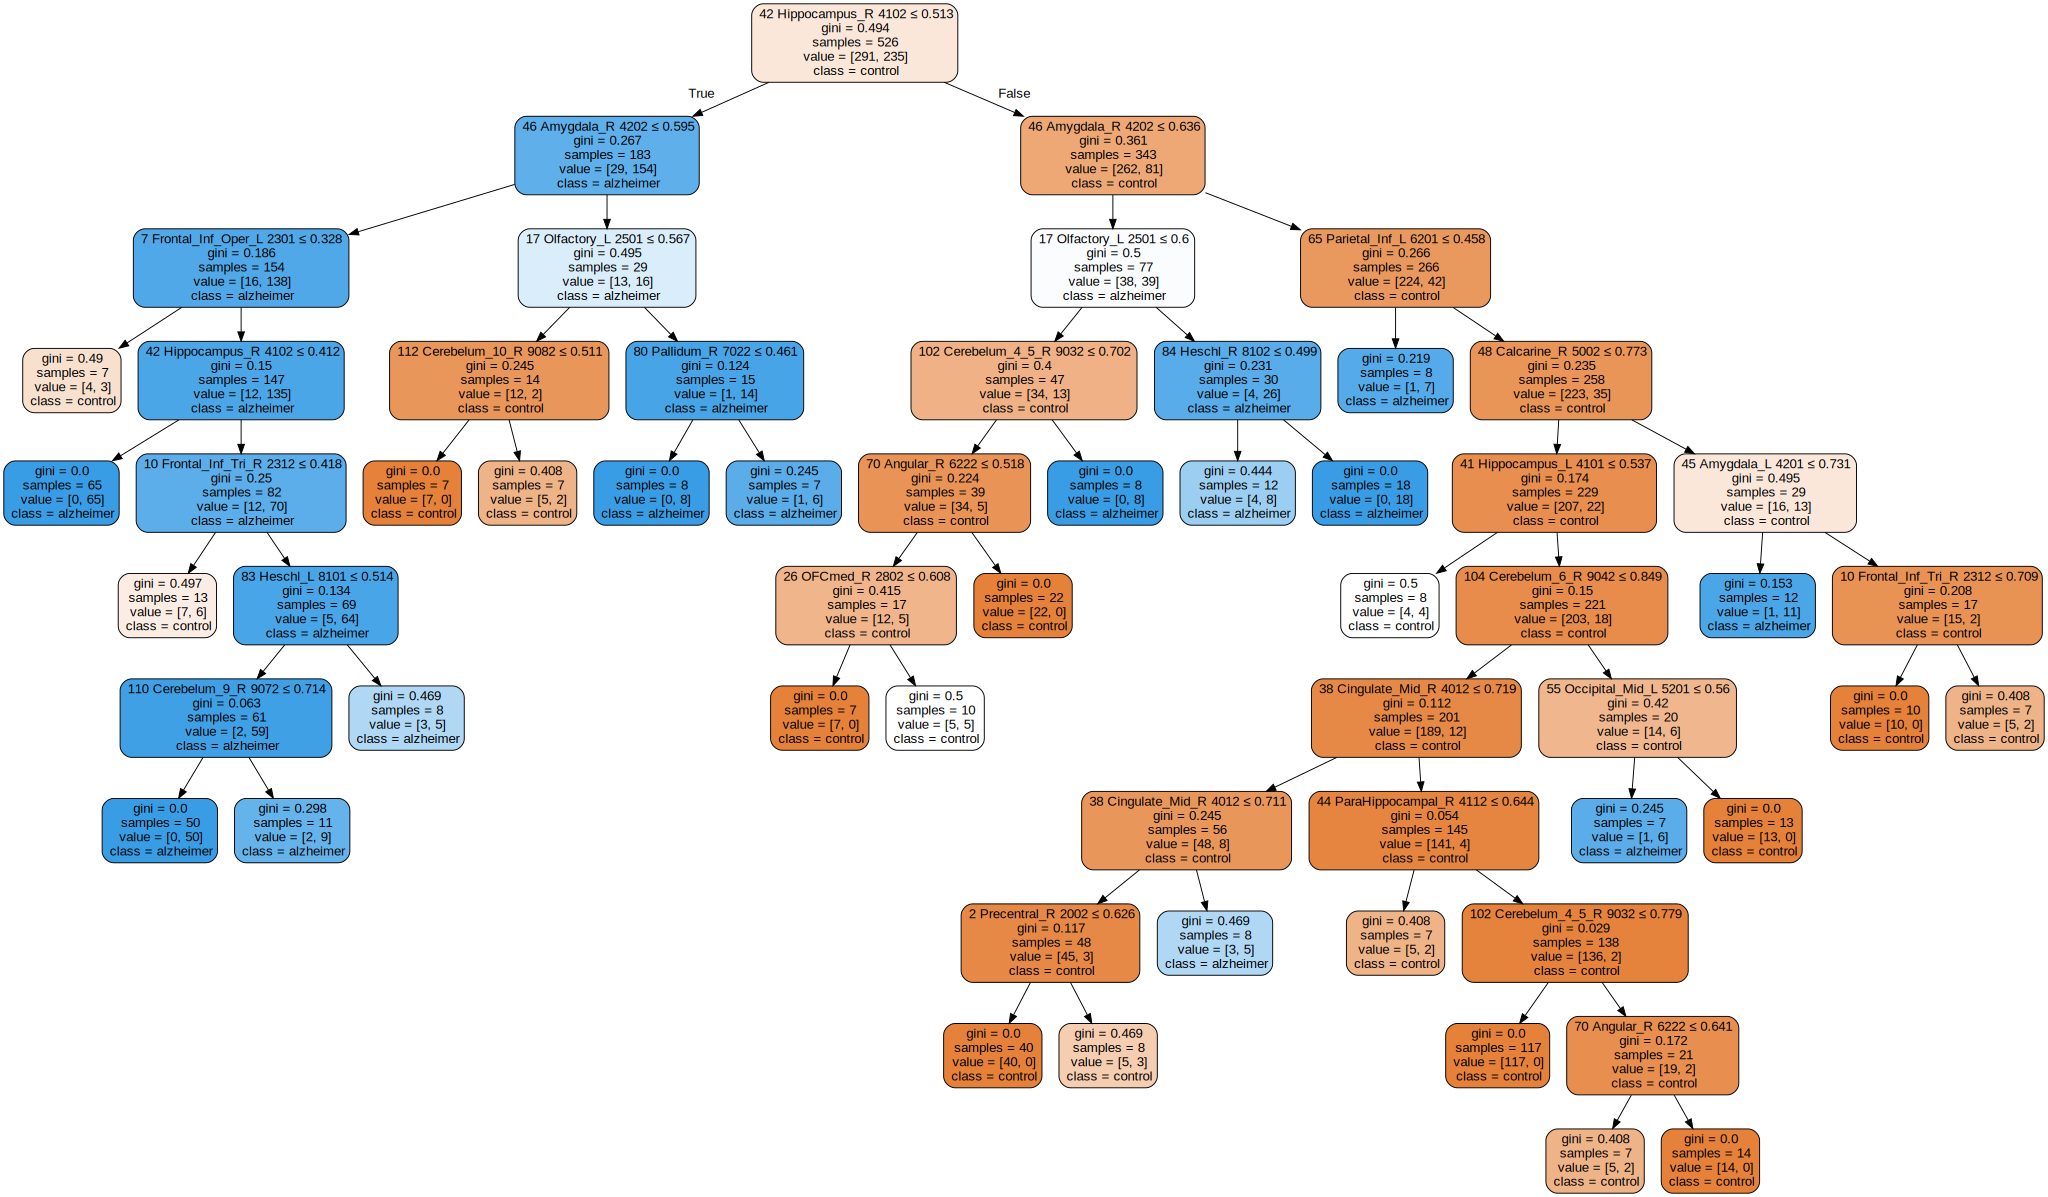

In [22]:
best_Tree = grid_tree.best_estimator_
dot_data = tree.export_graphviz(best_Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

It's remarkable how bagging make our model be less sensitive to noise on the data.

In [27]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag,  param_grid=p_grid_bagging, scoring='recall', cv=5)
grid_bagging.fit(X_train, np.ravel(y_train))
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.7404255319148935
Best params: {'n_estimators': 20}
Bagging test score : 0.7029702970297029


In [28]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag,  param_grid=p_grid_bagging, scoring='recall', cv=5)
grid_bagging.fit(X_train_temp, np.ravel(y_train))
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.7531914893617021
Best params: {'n_estimators': 20}
Bagging test score : 0.693069306930693


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [37]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='recall', cv=5)
grid_RF.fit(X_train, np.ravel(y_train))

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.7702127659574469
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 20}
Random Forest test score : 0.6732673267326733


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [50]:
best_params = grid_RF.best_params_
# Random Forest on noisy data
RF = RandomForestClassifier(min_samples_leaf = best_params["min_samples_leaf"],
                            max_features = best_params["max_features"],
                            n_estimators = best_params["n_estimators"], 
                            random_state = 0)

RF.fit(X_train_temp, np.ravel(y_train))

print("Random Forest test score :", RF.score(X_test,y_test))

Random Forest test score : 0.7920353982300885


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.141155)
2. feature 92 representing 93 Temporal_Inf_L 8301
 (0.063418)
3. feature 40 representing 41 Hippocampus_L 4101
 (0.059797)
4. feature 93 representing 94 Temporal_Inf_R 8302
 (0.055143)
5. feature 43 representing 44 ParaHippocampal_R 4112
 (0.050186)
6. feature 41 representing 42 Hippocampus_R 4102
 (0.038078)
7. feature 44 representing 45 Amygdala_L 4201
 (0.033012)
8. feature 42 representing 43 ParaHippocampal_L 4111
 (0.023431)
9. feature 59 representing 60 Fusiform_R 5402
 (0.020693)
10. feature 91 representing 92 Temporal_Pole_Mid_R 8212
 (0.016040)


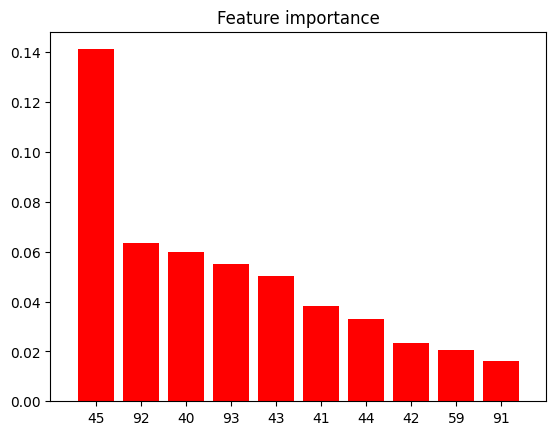

In [57]:
RF = RandomForestClassifier(min_samples_leaf = best_params["min_samples_leaf"],
                            max_features = best_params["max_features"],
                            n_estimators = best_params["n_estimators"],
                            random_state = 0)
RF.fit(X_train,np.ravel(y_train))

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

The three most important features are right side of Amygdala and the left side of Temporal and Hippocampus.   

We can also inspect the data using only pairs of the most important features

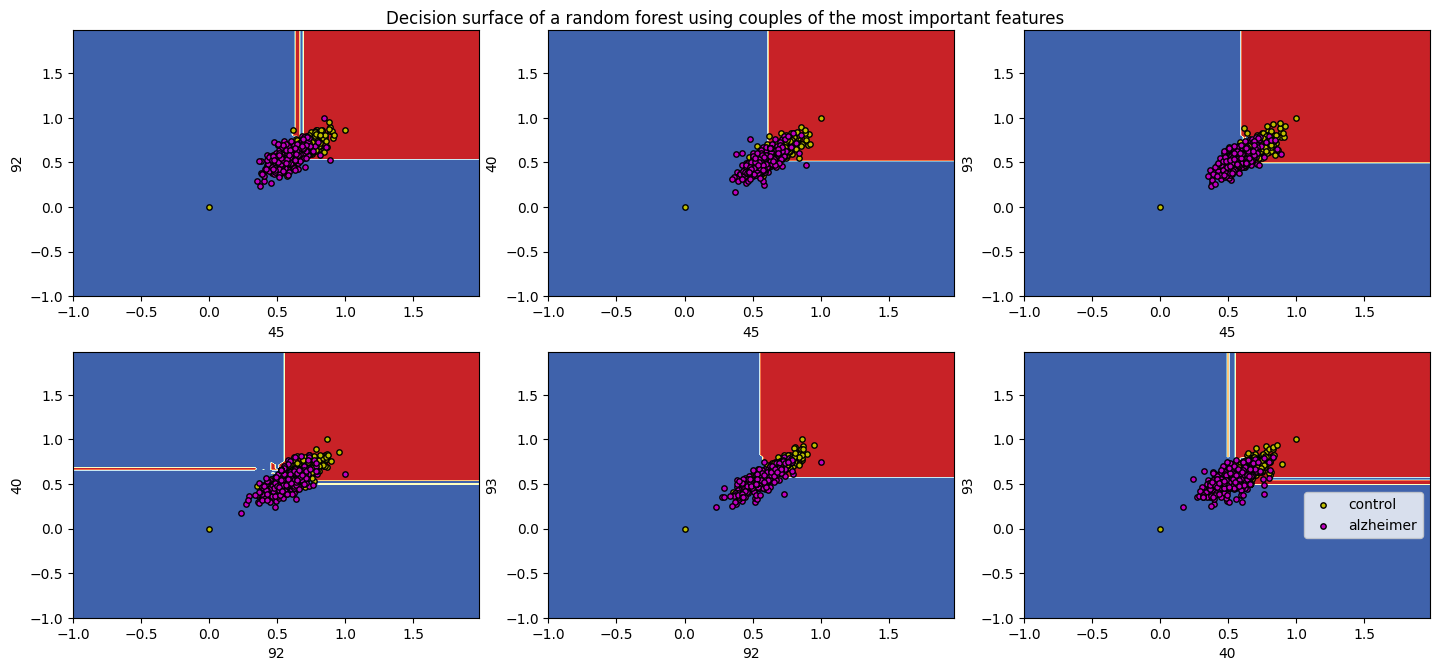

In [56]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, np.ravel(ypair))

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i], edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

The pair (45,93) and the pair (92,93) seen to be the best couple of features, since they tends to maximaze the data variation in one direction.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

Using **AICHA**

In [58]:
# Choose Atlas (here AAL2)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


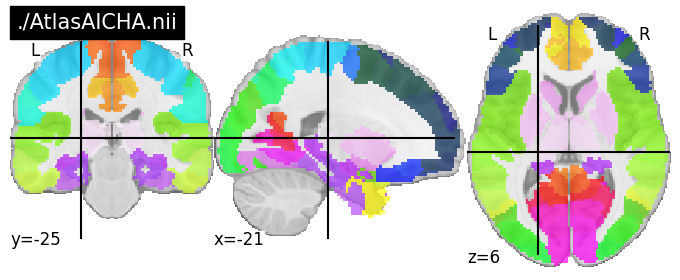

In [59]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

diveding the data in test and train

In [60]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

the minimum value of our data = 0.0


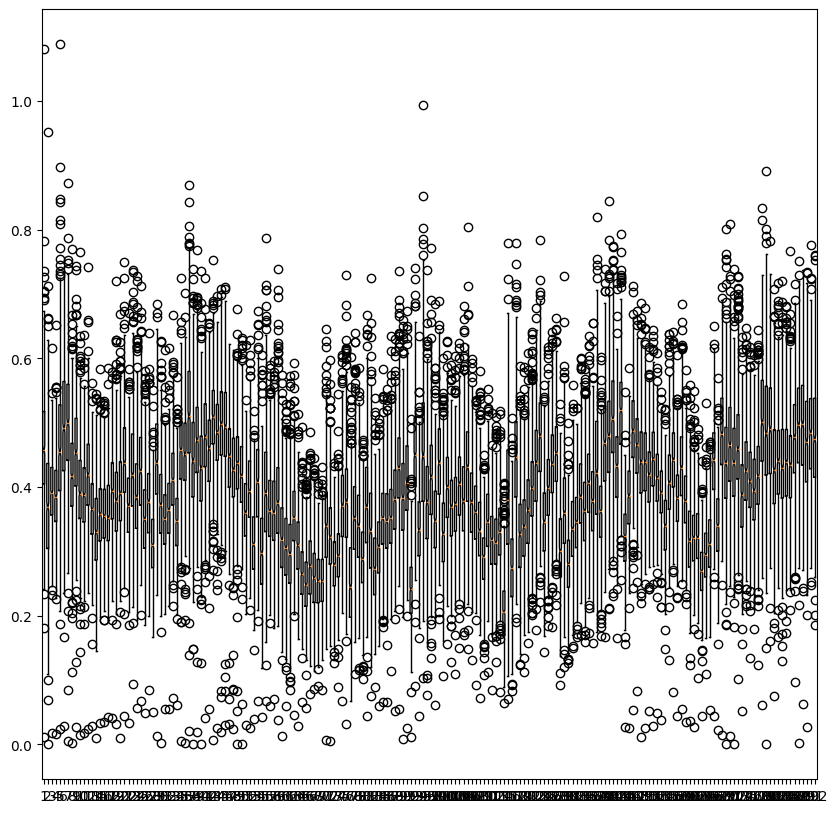

In [61]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

print(f"the minimum value of our data = {X.min()}")

In [62]:
# as always positive
# Normalization
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

we'll use Random Forest as classifier algorithm.

In [63]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='recall', cv=5)
grid_RF.fit(X_train, np.ravel(y_train))

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.7021276595744681
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 15}
Random Forest test score : 0.594059405940594


Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.077475)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.032928)
3. feature 189 representing 190	N_Thalamus-7	191
 (0.029337)
4. feature 181 representing 182	N_Putamen-2	183
 (0.025540)
5. feature 172 representing 173	N_Amygdala-1	174
 (0.024992)
6. feature 162 representing 163	G_ParaHippocampal-3	164
 (0.023575)
7. feature 180 representing 181	N_Pallidum-1	182
 (0.023155)
8. feature 170 representing 171	G_Fusiform-6	172
 (0.022896)
9. feature 145 representing 146	S_Parietooccipital-5	147
 (0.021323)
10. feature 94 representing 95	G_Temporal_Inf-2	96
 (0.020180)


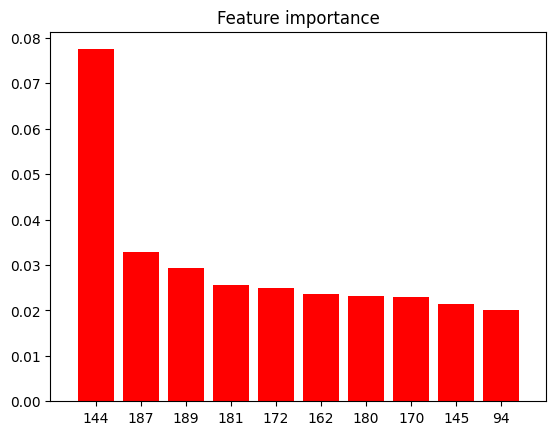

In [66]:
best_RF = grid_RF.best_estimator_
importances = best_RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Using **HAMMERS**

In [67]:
# Choose Atlas (here AAL2)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


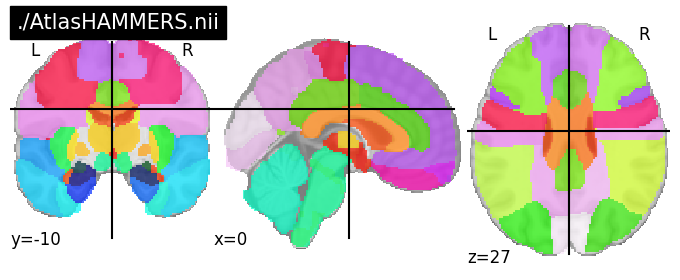

In [68]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In [69]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

the minimum value of our data = 0.0


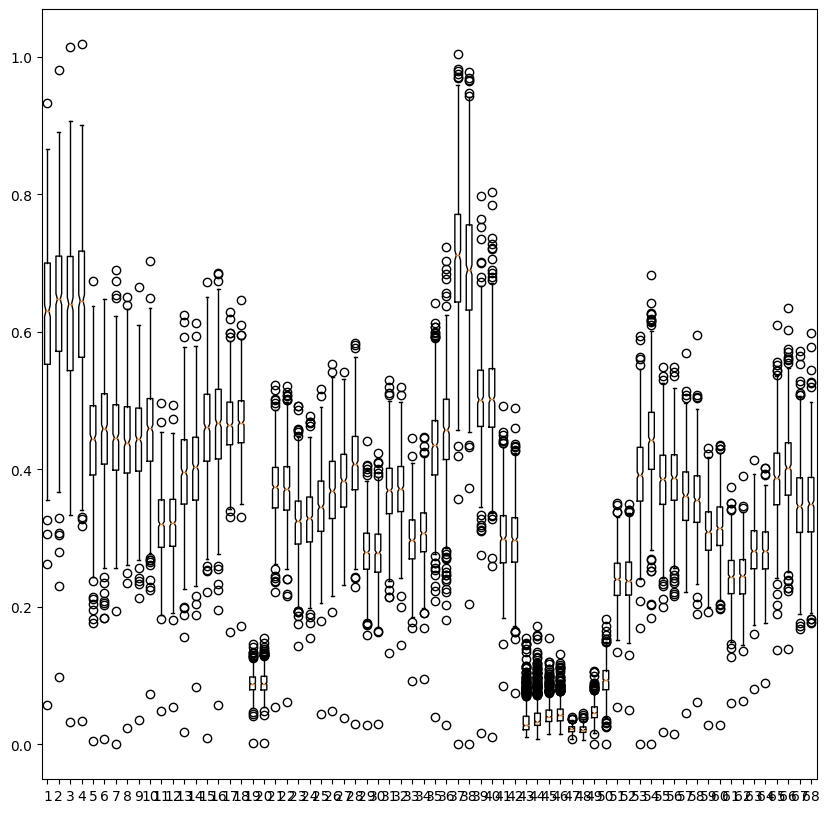

In [70]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

print(f"the minimum value of our data = {X.min()}")

In [71]:
# as always positive
# Normalization
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

In [72]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='recall', cv=5)
grid_RF.fit(X_train, np.ravel(y_train))

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.7914893617021276
Best params: {'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.7326732673267327


Feature ranking:
1. feature 3 representing Right Amygdala                         (0.124618)
2. feature 2 representing Left Amygdala                          (0.083997)
3. feature 46 representing Left Lateral Temporal Ventricle        (0.051319)
4. feature 0 representing Left Hippocampus                       (0.049102)
5. feature 1 representing Right Hippocampus                      (0.043183)
6. feature 47 representing Right Lateral Temporal Ventricle       (0.031899)
7. feature 5 representing Right Anterior Medial Temporal Lobe    (0.028597)
8. feature 4 representing Left Anterior Medial Temporal Lobe     (0.027466)
9. feature 12 representing Left Inferior Middle Temporal Gyri     (0.023229)
10. feature 13 representing Right Inferior Middle Temporal Gyri    (0.022942)


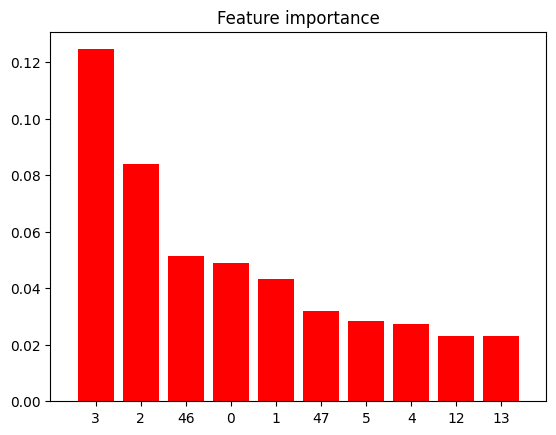

In [73]:
best_RF = grid_RF.best_estimator_
importances = best_RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

When we change the Atlas the features also changes (how the brain is divided and their names), so it changes the results. Although, we yet can see that some ROI are present as features with most importance, the Amygdala, for exemple, is a ROI that appeared on all top 5 ranks. Moreover, the left inferior temporal and also the Hippocampus are present in the top 5 in 2 of the 3 Atlas. 